In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
import tensorflow as tf
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from Env import MultiTradingEnv,State,Action
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import argparse
import gym
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
from torch.distributions import Categorical
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

2024-04-27 02:40:52.946683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 02:40:54.170381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import ta

def preprocess(data):
    long_sma_window = 50
    short_sma_window = 20
    data['feature_Long_SMA'] = data['Close'].rolling(window=long_sma_window, min_periods=1).mean()
    data['feature_Short_SMA'] = data['Close'].rolling(window=short_sma_window, min_periods=1).mean()
    data['feature_RSI'] = ta.momentum.rsi(close=data['Close'], window=14)
    data["feature_Close"] = data["Close"].pct_change()
    data["feature_Open"] = data["Open"]/data["Close"]
    data["feature_High"] = data["High"]/data["Close"]
    data["feature_Low"] = data["Low"]/data["Close"]
    data['feature_MACD'] = ta.trend.macd(data["Close"])
    data['feature_CCI'] = ta.trend.cci(data["High"], data["Low"], data["Close"], window=20)
    data['feature_BB_upper'], data['feature_BB_middle'], data['feature_BB_lower'] = ta.volatility.bollinger_hband(data["Close"]), ta.volatility.bollinger_mavg(data["Close"]), ta.volatility.bollinger_lband(data["Close"])
    data['feature_Slowk']= ta.momentum.stoch(data["High"], data["Low"], data["Close"])
    data['feature_ATR'] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)


In [6]:
stocks=['63MOONS.csv','NHPC.csv','BIOCON.csv','BHEL.csv']
stocks=['BSOFT.csv','BIRLACORPN.csv','BLUECOAST.csv','BLUEDART.csv']
stocks=['btc_30m.csv','ETH_1H.csv']

dataframes=[]
# stocks=['63MOONS.csv']
path='/home/siddharth/Desktop/MultiTrading/Datasets/SCRIP/'
path='/home/siddharth/Desktop/MultiTrading/'
timesteps=20000
for name in stocks:
    df=pd.read_csv(path+name)
    df=df[:timesteps]
    df=df[['Open','Close','High','Low','Volume']]
    df.reset_index(inplace=True,drop=True)
    dataframes.append(df)


In [8]:
norm_dataframes=[]
for i in range(len(dataframes)):
    df=dataframes[i]
    preprocess(df)
    dataframes[i]=df
    df = (df - df.min()) / (df.max() - df.min())
    norm_dataframes.append(df)
for i in norm_dataframes:
    print(i)

           Open     Close      High       Low    Volume  feature_Long_SMA  \
0      0.712507  0.714316  0.719236  0.716975  0.011822          0.759644   
1      0.712738  0.700376  0.716012  0.695237  0.028550          0.758282   
2      0.700396  0.703220  0.709182  0.702868  0.016140          0.757122   
3      0.702006  0.696794  0.719197  0.690508  0.039337          0.755813   
4      0.696816  0.717098  0.719197  0.696485  0.029642          0.755292   
...         ...       ...       ...       ...       ...               ...   
19970  0.071575  0.071493  0.071769  0.072772  0.051407          0.061890   
19971  0.071574  0.071825  0.071326  0.072559  0.051201          0.062221   
19972  0.071887  0.071095  0.071255  0.072424  0.046980          0.062532   
19973  0.071188  0.071398  0.070909  0.071966  0.043795          0.062847   
19974  0.071423  0.071247  0.071096  0.072505  0.043634          0.063160   

       feature_Short_SMA  feature_RSI  feature_Close  feature_Open  \
0    

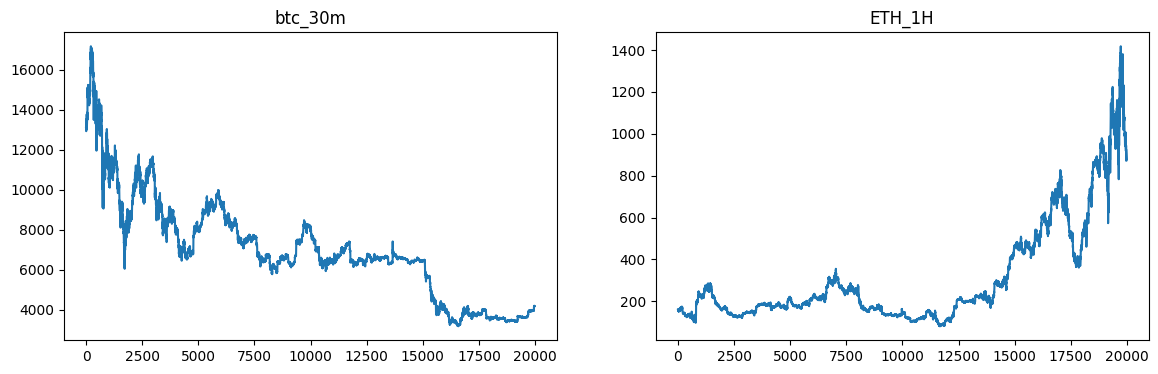

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def create_subplots(n,df=dataframes,st=stocks):
    fig, axes = plt.subplots(1, n, figsize=(7*n, 2*n))
    for i in range(n):
        data = df[i]['Open']
        axes[i].plot(data)
        axes[i].set_title(st[i][:-4])
    plt.show()
n = len(dataframes)
create_subplots(n,df=dataframes,st=stocks)

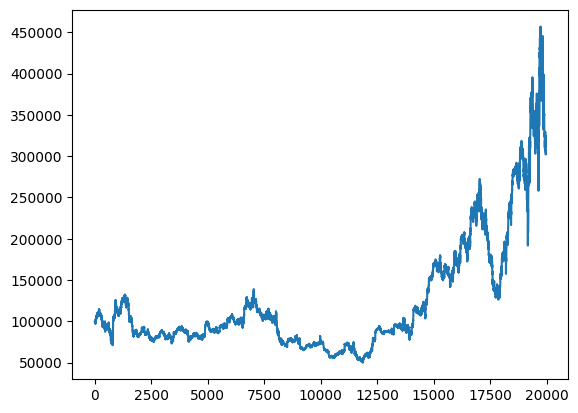

In [10]:
num_stocks=2
tmp=np.zeros(shape=(len(dataframes[0])))
cnt=0
wts=np.ones(num_stocks)/num_stocks
for i in dataframes:
    num=(100000*wts[cnt])/np.array(i['Open'][0])
    ar=np.array(i['Open'])*num
    tmp+=ar
    cnt+=1
tmp=tmp[5:-15]
tmp/=tmp[0]
tmp*=100000
plt.plot(tmp)

In [12]:

import itertools
num_stocks=len(dataframes)
boxes=2*num_stocks
rng = list(range(boxes + 1)) * num_stocks
wt_combs=[]
lol=set(i for i in itertools.permutations(rng, num_stocks) if sum(i) == boxes)
for i in lol:
    wt_combs.append(i)
wt_combs=np.array(wt_combs)
wt_combs_norm=wt_combs/boxes
print(len(wt_combs_norm))



5


In [9]:
from Env import MultiTradingEnv;
LOOKBACK=1
step=0.05
positions=np.arange(0,1,step)
positions=np.append(positions,1)
print(positions)
env = MultiTradingEnv(dataframes_array=dataframes,
                      norm_dataframes=norm_dataframes,
                       total_timesteps=len(dataframes[0])-LOOKBACK-1,
                       initial_cap=100000.0,
                       features=dataframes[0].columns,
                       lookback=LOOKBACK,
                       positions=positions,
                       wt_combs=wt_combs_norm,
                       )

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


In [13]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [14]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -keras.ops.mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)


In [15]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model


In [16]:
def policy(state, noise_object):
    sampled_actions = keras.ops.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]


In [14]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)


2024-04-27 02:36:14.483595: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):
    prev_state, _ = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, truncated, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        # End this episode when `done` or `truncated` is True
        if done or truncated:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()


Episode * 0 * Avg Reward is ==> -1439.671977730771
Episode * 1 * Avg Reward is ==> -1477.1751984823754
Episode * 2 * Avg Reward is ==> -1533.256714997762
Episode * 3 * Avg Reward is ==> -1543.3579989294153
Episode * 4 * Avg Reward is ==> -1551.3512414492252
Episode * 5 * Avg Reward is ==> -1549.2548008917527
Episode * 6 * Avg Reward is ==> -1502.5607552433416
Episode * 7 * Avg Reward is ==> -1463.263454514568
Episode * 8 * Avg Reward is ==> -1419.2754750334088
Episode * 9 * Avg Reward is ==> -1358.424769610047
Episode * 10 * Avg Reward is ==> -1260.0288654971764
Episode * 11 * Avg Reward is ==> -1285.6326304942017
Episode * 12 * Avg Reward is ==> -1305.2074140336554
Episode * 13 * Avg Reward is ==> -1212.613520381206
Episode * 14 * Avg Reward is ==> -1235.0803894103408
Episode * 15 * Avg Reward is ==> -1166.11245177042
Episode * 16 * Avg Reward is ==> -1177.5230776974918
Episode * 17 * Avg Reward is ==> -1112.1766252618731
Episode * 18 * Avg Reward is ==> -1067.3378657366313
Episode * 

KeyboardInterrupt: 

: 